In [23]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version in torch:", torch.version.cuda)
print("Is torch built with CUDA:", torch.backends.cuda.is_built())


Torch version: 2.8.0+cu126
CUDA available: True
CUDA version in torch: 12.6
Is torch built with CUDA: True


In [24]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Using device:", device)

import numpy as np
import torch.nn as nn
import torch.nn.functional as F


Using device: cuda


In [25]:
import json

with open("../tokenizer_data/vocab.json", "r", encoding="utf-8") as f:
    vocab = json.load(f)

vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Vocabulary size: 2439


In [26]:
flattened = np.memmap(
    "../tokenized_sql_dataset/flatten_token.memmap",
    dtype=np.int32,
    mode="r"
)

In [27]:
class DataLoader:
    def __init__(self, memmap_path: str, block_size: int, dtype = np.int32, start=0, end=None):
        self.tokens =  np.memmap(memmap_path, dtype=dtype, mode='r')
        self.block_size = block_size
        self.total_tokens = len(self.tokens)

        self.end = len(self.tokens) - block_size if end is None else end
        self.start = start
        self.length = self.end - self.start


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx += self.start
        if idx + self.block_size + 1 > self.end:
            raise IndexError("Index out of bounds.")
        block = self.tokens[idx : idx + self.block_size + 1]
        x = torch.tensor(block[:-1], dtype=torch.long)
        y = torch.tensor(block[1:], dtype=torch.long)
        return x, y

    def get_batch(self, batch_size: int, device='cpu'):
        idxs = np.random.randint(0, self.length, size=batch_size)
        x_list, y_list = zip(*[self[i] for i in idxs])
        x = torch.stack(x_list).to(device)
        y = torch.stack(y_list).to(device)
        return x, y

    @staticmethod
    def collate_fn(batch):
        x = torch.stack([item[0] for item in batch])
        y = torch.stack([item[1] for item in batch])
        return x, y

In [28]:
n_data = len(flattened)
n_data

train_batch_size = 16  # training batch size
eval_batch_size = 8  # evaluation batch size
context_length = 256  # number of tokens processed in a single batch
block_size = 256
train_split = 0.9  # percentage of data to use from total data for training

In [29]:
usable_tokens = n_data - block_size
split_ratio = 0.9
split_index = int(usable_tokens * split_ratio)

In [30]:
memmap_path = "../tokenized_sql_dataset/flatten_token.memmap"

train_loader = DataLoader(
        memmap_path=memmap_path,
        block_size=block_size,
        dtype=np.int32,
        start=0,
        end=split_index
    )

eval_loader = DataLoader(
        memmap_path=memmap_path,
        block_size=block_size,
        dtype=np.int32,
        start=split_index,
        end=usable_tokens  # to avoid index errors
    )


In [31]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, d_model) # word token embeddings
        self.lm_head = nn.Linear(d_model, vocab_size)

    # def forward(self, inputs, targets = None):
    #     logits = self.wte(inputs) # dim -> batch_size, sequence_length, d_model
    #     loss = None
    #     if targets != None:
    #         batch_size, sequence_length, d_model = logits.shape
    #         # to calculate loss for all token embeddings in a batch
    #         # kind of a requirement for cross_entropy
    #         logits = logits.view(batch_size * sequence_length, d_model)
    #         targets = targets.view(batch_size * sequence_length)
    #         loss = F.cross_entropy(logits, targets)
    #     return logits, loss

    def forward(self, inputs, targets=None):
        x = self.wte(inputs)                                   # [B, T, d_model]
        logits = self.lm_head(x)                               # [B, T, vocab_size]

        loss = None
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B * T, V)                     # flatten for CE
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        # this will store the model outputs along with the initial input sequence
        # make a copy so that it doesn't interfare with model
        for _ in range(max_new_tokens):
            # we only pass targets on training to calculate loss
            logits, _ = self(inputs)
            # for all the batches, get the embeds for last predicted sequence
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            # get the probable token based on the input probs
            idx_next = torch.multinomial(probs, num_samples=1)

            inputs = torch.cat([inputs, idx_next], dim=1)
        # as the inputs has all model outputs + initial inputs, we can use it as final output
        return inputs

In [32]:
basic_model = GPT(vocab_size=2439, d_model=256).to(device)
lr = 1e-3
optimizer = torch.optim.AdamW(basic_model.parameters(), lr=lr)

In [33]:
from tqdm import trange, tqdm

epochs = 1000
eval_steps = 50  # perform evaluation every n steps

train_loss = {}

for ep in trange(epochs, desc="Training Epochs"):
    xb, yb = train_loader.get_batch(train_batch_size, device)

    logits, loss = basic_model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    train_loss[ep] = loss.item()

    if ep % eval_steps == 0 or ep == epochs - 1:
        basic_model.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch(eval_batch_size, device)
            _, e_loss = basic_model(xvb, yvb)

            tqdm.write(f"Epoch: {ep}\ttrain_loss: {loss.item():.4f}\teval_loss: {e_loss.item():.4f}")
        basic_model.train()  # back to training mode


Training Epochs:   1%|          | 11/1000 [00:00<00:37, 26.66it/s]

Epoch: 0	train_loss: 7.9487	eval_loss: 7.9103


Training Epochs:   6%|▋         | 64/1000 [00:01<00:12, 75.74it/s]

Epoch: 50	train_loss: 5.0124	eval_loss: 5.3760


Training Epochs:  12%|█▏        | 118/1000 [00:01<00:10, 84.61it/s]

Epoch: 100	train_loss: 3.6356	eval_loss: 4.2923


Training Epochs:  16%|█▋        | 163/1000 [00:02<00:09, 85.33it/s]

Epoch: 150	train_loss: 3.3063	eval_loss: 3.7505


Training Epochs:  22%|██▏       | 219/1000 [00:02<00:08, 86.93it/s]

Epoch: 200	train_loss: 3.1197	eval_loss: 3.4938


Training Epochs:  26%|██▋       | 264/1000 [00:03<00:08, 85.74it/s]

Epoch: 250	train_loss: 2.8994	eval_loss: 3.4557


Training Epochs:  32%|███▏      | 318/1000 [00:04<00:07, 87.15it/s]

Epoch: 300	train_loss: 3.0723	eval_loss: 3.5598


Training Epochs:  36%|███▋      | 363/1000 [00:04<00:07, 85.02it/s]

Epoch: 350	train_loss: 3.1095	eval_loss: 3.3743


Training Epochs:  42%|████▏     | 417/1000 [00:05<00:06, 84.04it/s]

Epoch: 400	train_loss: 2.8456	eval_loss: 3.4861


Training Epochs:  46%|████▌     | 462/1000 [00:05<00:06, 85.45it/s]

Epoch: 450	train_loss: 2.9624	eval_loss: 3.3361


Training Epochs:  51%|█████     | 508/1000 [00:06<00:05, 82.60it/s]

Epoch: 500	train_loss: 2.9142	eval_loss: 3.3321


Training Epochs:  56%|█████▋    | 563/1000 [00:07<00:05, 85.50it/s]

Epoch: 550	train_loss: 2.9783	eval_loss: 3.2849


Training Epochs:  61%|██████    | 609/1000 [00:07<00:04, 81.76it/s]

Epoch: 600	train_loss: 3.0021	eval_loss: 3.4843


Training Epochs:  66%|██████▋   | 664/1000 [00:08<00:03, 85.46it/s]

Epoch: 650	train_loss: 2.8525	eval_loss: 3.4028


Training Epochs:  71%|███████   | 709/1000 [00:08<00:03, 79.79it/s]

Epoch: 700	train_loss: 2.9386	eval_loss: 3.6338


Training Epochs:  76%|███████▋  | 763/1000 [00:09<00:02, 85.22it/s]

Epoch: 750	train_loss: 2.7853	eval_loss: 3.4897


Training Epochs:  81%|████████  | 808/1000 [00:10<00:02, 80.73it/s]

Epoch: 800	train_loss: 2.9183	eval_loss: 3.2575


Training Epochs:  86%|████████▋ | 863/1000 [00:10<00:01, 83.27it/s]

Epoch: 850	train_loss: 3.0559	eval_loss: 3.3384


Training Epochs:  92%|█████████▏| 917/1000 [00:11<00:01, 81.98it/s]

Epoch: 900	train_loss: 2.9717	eval_loss: 3.2484


Training Epochs:  96%|█████████▌| 962/1000 [00:11<00:00, 82.14it/s]

Epoch: 950	train_loss: 2.8732	eval_loss: 3.3679


Training Epochs: 100%|██████████| 1000/1000 [00:12<00:00, 81.00it/s]

Epoch: 999	train_loss: 2.9201	eval_loss: 3.3150


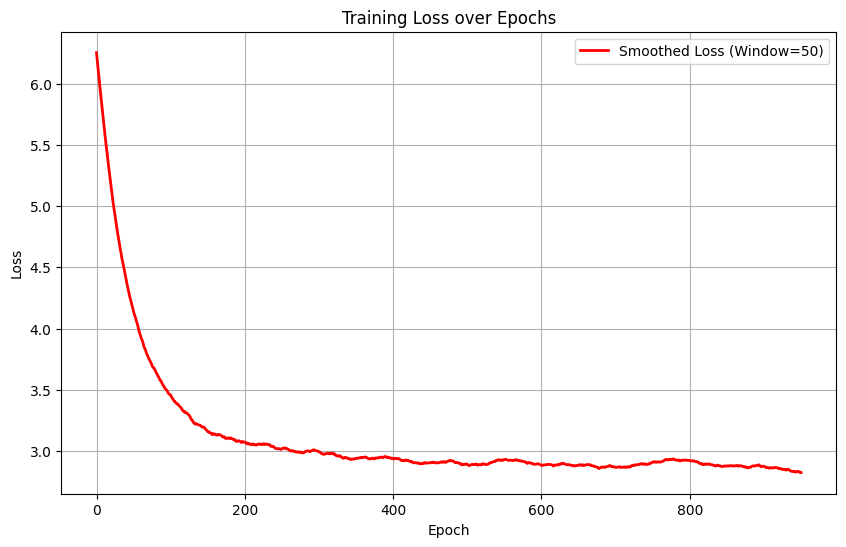

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loss is your dictionary with epoch and loss
epochs = list(train_loss.keys())
losses = list(train_loss.values())

# Smoothing parameters
smooth_window = 50  # Adjust the window size for smoothing

# Smoothed losses using moving average
smoothed_losses = np.convolve(losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from bpe.fast_token import FastBPETokenizer
tokenizer = FastBPETokenizer()

tokenizer.load("../tokenizer_data")
tokens = tokenizer.tokenize_to_ids("find")

In [ ]:
text = ''''Which tests have 'Pass' results? Return the dates when the tests were taken, and count them by a line chart, and I want to display by the X-axis in asc.
CREATE TABLE Courses (course_id INTEGER,author_id INTEGER,subject_id INTEGER,course_name VARCHAR(120),course_description VARCHAR(255))
CREATE TABLE Student_Course_Enrolment (registration_id INTEGER,student_id INTEGER,course_id INTEGER,date_of_enrolment DATETIME,date_of_completion DATETIME)CREATE TABLE Student_Tests_Taken (registration_id INTEGER,date_test_taken DATETIME,test_result VARCHAR(255))CREATE TABLE Students (student_id INTEGER,date_of_registration DATETIME,date_of_latest_logon DATETIME,login_name VARCHAR(40),password VARCHAR(10),personal_name VARCHAR(40),middle_name VARCHAR(40),family_name VARCHAR(40))CREATE TABLE Subjects (subject_id INTEGER,subject_name VARCHAR(120))CREATE TABLE Course_Authors_and_Tutors (author_id INTEGER,author_tutor_ATB VARCHAR(3),login_name VARCHAR(40),password VARCHAR(40),personal_name VARCHAR(80),middle_name VARCHAR(80),family_name VARCHAR(80),gender_mf VARCHAR(1),address_line_1 VARCHAR(80))
=>
'''


input_tokens = torch.tensor(tokenizer.tokenize_to_ids(text), dtype=torch.long)

In [ ]:
basic_model.eval()

with torch.no_grad():
    logits, _ = basic_model(input_tokens)
    predicted_ids = torch.argmax(logits, dim=-1)  # pick the most likely token at each position

print("Predicted token IDs:", predicted_ids)


Predicted token IDs: tensor([ 81,  36,  58,  96, 132, 259, 198, 118,   9,  93,  36, 208, 189, 149,
         36,   9, 116, 120, 175,  90, 149,  36,   9,  67,  89,  90, 138, 286,
        254, 184,  89,   9, 146, 264, 254, 198, 118,   9,  90, 264,  90, 136,
        132, 105,  93, 211, 255, 207,  99, 259, 264, 120, 175, 244, 259,  15,
         90, 105,  93, 283,  90, 164, 207, 258, 184, 251, 118, 280, 264, 254,
         73,  21, 183,  36, 264, 264, 189, 211,  52,  76, 254,  73, 249, 149,
          9,  61, 211, 249, 200, 207,  66,  73,  36,  70,  54,  70,  67,   7,
        183, 252, 201, 254, 207,  66,  73,  36,  70,  54,  70,  67,   7, 120,
        188, 140, 254,  90, 207,  66,  73,  36,  70,  54,  70,  67,   7, 211,
        249, 200, 125, 102, 259,  45,  70,  67,  73,  54,  70,  67,  61,  36,
         23,  15,   7, 211, 249, 200, 125, 184, 125, 211, 230, 115, 258,  45,
         70,  67,  73,  54,  70,  67,  61,  36,  10,  10,  15,  41,  76, 254,
         54,  90, 252, 184, 247, 125,  73, 

In [ ]:
predicted_ids = predicted_ids.tolist()
decode = tokenizer.decode_from_ids(predicted_ids)
print("Decoded output:", decode)

Decoded output: W Haddtext,may(a  oker (ationbigh_id er (O__id e whtis_(en the tmay(_id the _id edand a odt number,altext,the bighstext,,_id and a w_id gnumber,textissiayvthe tT0ir the the kodCREATE TABLE tTseer(Id odsemenumber,NT RERO'irstntnumber,NT RERO'bject_id number,NT RERO'odsemecame text,AROTEROId  2,'odsemeciscodpatitextAROTEROId  )),=TABLE tE_id stiss cTsemecRame wigh_id (Id ationeeayuDnumber,NT RERO'aystiss number,NT RERO'odsemenumber,NT RERO'is_cstlcdwigh_id (ate ER N R'is_cstlcpati_textate ER N RTABLE tE_id stiss c _ayerc ethe Id ationeeayuDnumber,NT RERO'is_cmayc_id ethe ate ER N R'maycationbighnumber,AROTEROId  )),TABLE tE_id stiss (Id aystiss number,NT RERO'is_cstlcationeeayutext,ate ER N R'is_cstlcigh_aycighstetext,ate ER N R'ighstescame text,AROTEROId  0,'atiker_id ttext,AROTEROId  0,'ier_,came text,AROTEROId  0,'_id ,is_came text,AROTEROId  0,'ledpcame text,AROTEROId  0,TABLE tEstject(Id bject_id number,NT RERO'bject_id came text,AROTEROId  2,TABLE tTsemecRstntercgis

In [ ]:
input_tokens = input_tokens.unsqueeze(0).to(device)

In [ ]:
with torch.no_grad():
    generated = basic_model.generate(input_tokens, max_new_tokens=200)

generated_ids = generated[0].tolist()
decode = tokenizer.decode_from_ids(generated_ids)
print("Decoded output:", decode)

Decoded output: <bos>'Which tests have 'Pass' results? Return the dates when the tests were taken, and count them by a line chart, and I want to display by the X-axis in asc. CREATE TABLE Courses (course_id INTEGER,author_id INTEGER,subject_id INTEGER,course_name VARCHAR(120),course_description VARCHAR(255)) CREATE TABLE Student_Course_Enrolment (registration_id INTEGER,student_id INTEGER,course_id INTEGER,date_of_enrolment DATETIME,date_of_completion DATETIME)CREATE TABLE Student_Tests_Taken (registration_id INTEGER,date_test_taken DATETIME,test_result VARCHAR(255))CREATE TABLE Students (student_id INTEGER,date_of_registration DATETIME,date_of_latest_logon DATETIME,login_name VARCHAR(40),password VARCHAR(10),personal_name VARCHAR(40),middle_name VARCHAR(40),family_name VARCHAR(40))CREATE TABLE Subjects (subject_id INTEGER,subject_name VARCHAR(120))CREATE TABLE Course_Authors_and_Tutors (author_id INTEGER,author_tutor_ATB VARCHAR(3),login_name VARCHAR(40),password VARCHAR(40),personal_